# LPR 2.0 but with one plate and a CNN?

### Notes ###

* for first thresholding, best value seems to be 3 (t_mod). it is darker but helps with separating additional plates
    * best to err on the side of a little dark, then let avg_mod space_thresh separate properly
* for second and third thresholding (horizontal then second vertical cuts, respectively) -- assuming that a bit lighter is better. check this
* the avg_mod for space_thresh doesn't seem to make a difference until the image is darker, at which point a higher mod is good. 3 seems to be a sweet spot 

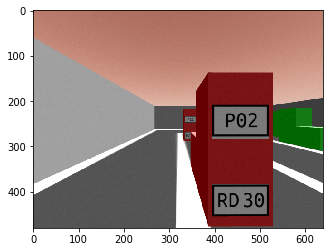

In [97]:
# get image from robot.

import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import statistics as sts

# get path to this directory
path = os.getcwd() + "/test_imgs/"  # gets current working directory. is "hacky" (replace this with os.path or smth on vs)

img_names = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
test_img_list = [cv2.imread(path + img_names[0])]

plt.imshow(test_img_list[0])
plt.show()

### segment image THIS IS UPDATED NOW UPDATE IT PLS PLS
1. Convert to greyscale, then threshold to get clearer letters

2. Process to make sure there arent any false positives 
   * blur
   * ?? hopefully it will be good after the blur
    
3. Get vertical total (or average or whatever) pixel val
    * if it is under a certain threshold, theres no letter there
    
4. Chop up image

## Function to segment stuff
This gets the average pixel value along either vertical or horizonal lines in the image, then decides where the letters are based on when the value changes

In [4]:
''' 
image_list = a list of images to split. these should be greyscale

t_mod = to modify the threshold value for greyscaling image. 
            defaults to 3 (best val for first split). 
            probably needs to be changed for other splits
            
horizontal = True if splitting the image horizontally. default True

avg_mod = to pull the space-threshold value towards the average pixel value. 
            defaults to 3 based on testing done (most robust)
            
min_len = the minimum allowed length of chunk (pixels)
    
    
returns: chunks = a list of lists of indices to split the image with, with:
    len(chunks) = len(image_list)
    chunks[*] = list of pairs corresponding to image[*]
'''


def split_images(image_list, horizontal=True, avg_mod=3, t_mod=3.3, min_len=5):

    chunks = []
    count = 0
    
    for img_g in image_list:
        ''' threshold the image based on average pixel val, then blur '''
        grey_thresh = np.mean(img_g)/t_mod
        _, img_b = cv2.threshold(img_g, grey_thresh, 255, cv2.THRESH_BINARY)
        
        h, w = img_b.shape
        b = 5
        if w < 100:
            b = 2
            
        img = cv2.blur(img_b, (b,b))
        
        # print(count)
        # count += 1
        plt.imshow(img)
        plt.show()
        
        ''' get average pix val for each row '''
        pix_vals = []
        
        if horizontal:
            for i in range(h):
                pix_sum = 0
                for j in range(w):
                    pix_sum += img[i,j]
                pix_vals.append(pix_sum/w)
            # plt.plot(pix_vals, range(h))
            # plt.show()
            
        else:
            for i in range(w):
                pix_sum = 0
                for j in range(h):
                    pix_sum += img[j,i]
                pix_vals.append(pix_sum/h)
            # plt.plot(range(w), pix_vals)
            # plt.show()
      

        ''' 
        find where the average vals dip below a certain
        threshold, and count until they rise above that 
        threshold 
        '''
        avg_val = sts.mean(pix_vals)
        # print("average val: {}".format(avg_val))

        pix_vals_temp = pix_vals
        for i in range(50):
            try:
                # print("OOOOOOOOOO")
                mode_val = sts.mode(pix_vals_temp)
                # print("mode: {}".format(mode_val))
                break
            except sts.StatisticsError:
                print("Multiple modes")
                # increase every other thing by one
                for j in range(len(pix_vals_temp)):
                    if j % (i+1) == 0:
                        pix_vals_temp[j] += 1
        
        space_thresh = mode_val - abs(mode_val-avg_val)*(255-avg_val)*(255-avg_val)*(255-avg_val)*avg_mod/(255*255*255)
        # print("space thresh: {}".format(space_thresh))
        
        temp = []
        i = 0
        keep_going = False
        while i in range(len(pix_vals)):
            if(pix_vals[i] < space_thresh):

                if not keep_going:  # this is for if the previous chunk was determined too small
                    start = i

                while(pix_vals[i] < space_thresh):
                    i += 1
                    if i not in range(len(pix_vals)):
                        break
                        
                ''' 
                check if the chunk is very small. if it is, then
                keep the starting position and keep going 
                '''      
                if(abs(start-i) > 5):  # if its really short, keep going (assume its stopping too early)
                    if(abs(start-i) > min_len): # throw away anything that isn't above minimum length
                        temp.append([start, i])
                    keep_going = False
                    
                else:
                    keep_going = True

            i += 1

        if len(temp) < 1:
            temp = [] # this might already be the case but i just want to be sure lol
        
        chunks.append(temp)
    
    return chunks

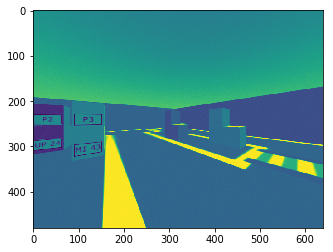

In [5]:
# 1) Convert to greyscale

grey_img_list = []

for test_img in test_img_list:
    grey_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
    grey_img_list.append(grey_img)

    plt.imshow(grey_img)
    plt.show()


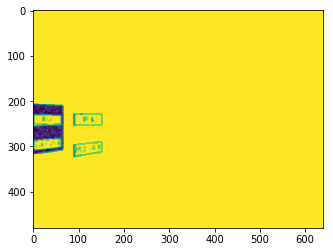

from image 0


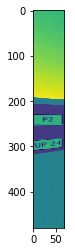

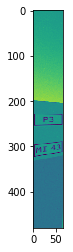

In [6]:
# split into strips vertically
chunks = split_images(grey_img_list, horizontal=False, min_len=25)

# 1D list of all vertical strips
new_images = []

for i in range(len(chunks)):
    print("from image {}".format(i))
    for chunk in chunks[i]:
        new_images.append(grey_img_list[i][:, chunk[0]:chunk[1]])
        plt.imshow(grey_img_list[i][:, chunk[0]:chunk[1]])
        plt.show()

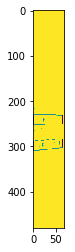

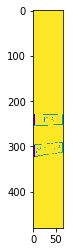

i = 0


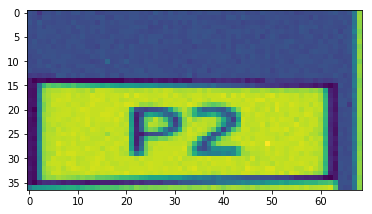

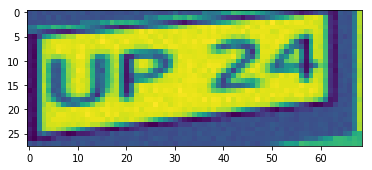

i = 1


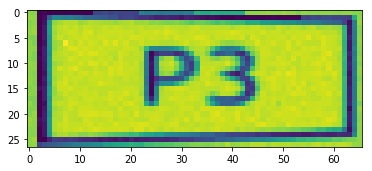

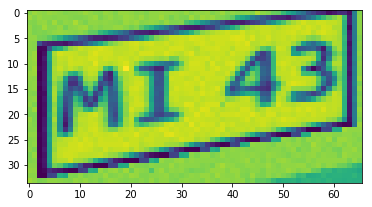

In [7]:
# now split each chunk horizontally
    
chunks_2 = split_images(new_images, horizontal=True, t_mod=5, min_len=10)

# a 2D list: a list of pairs of plates (each vertical strip should be two plates)
plate_pairs = []

for i in range(len(chunks_2)):
    print("i = {}".format(i))
    plate_pairs.append([])
    for chunk in chunks_2[i]:
        plate_pairs[i].append(new_images[i][chunk[0]:chunk[1], :])
        plt.imshow(new_images[i][chunk[0]:chunk[1], :])
        plt.show()
    

before splitting


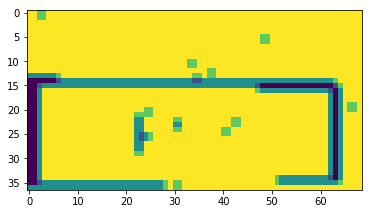

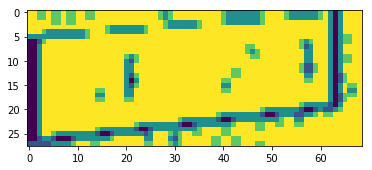

after splitting


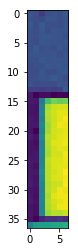

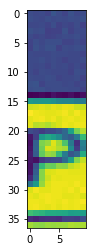

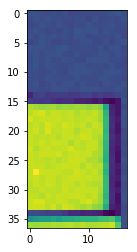

after splitting


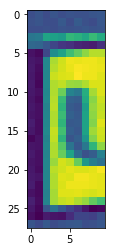

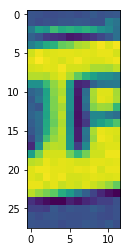

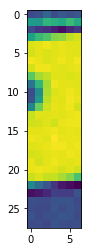

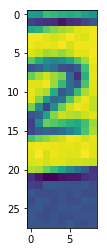

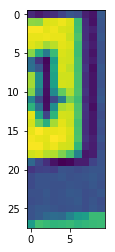

before splitting


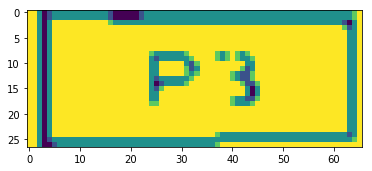

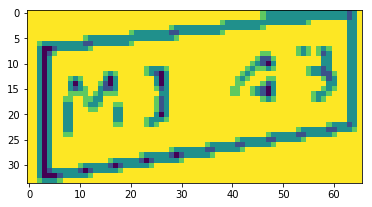

after splitting


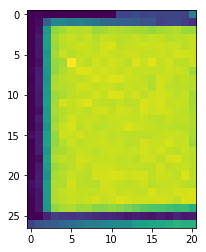

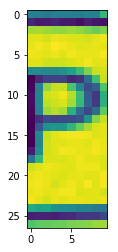

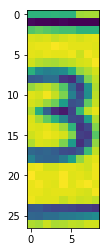

after splitting


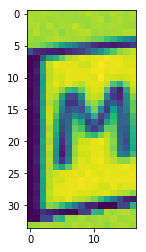

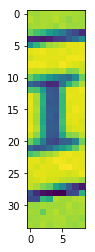

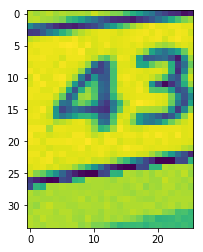

In [8]:
# now take each pair of license plates and vertically split them again

# each split_plates[i] should contain two lists, one of the parking spot (size 2) and one of the plate (size 4)
split_plates = []

for i in range(len(plate_pairs)):
    split_plates.append([])
    print("before splitting")
        
    chunks_3 = split_images(plate_pairs[i], horizontal=False, t_mod=2.5, avg_mod=5)
    
    for j in range(len(chunks_3)):
        print("after splitting")
        
        split_plates[i].append([])
        
        for chunk in chunks_3[j]:
            split_plates[i][j].append(plate_pairs[i][j][:, chunk[0]:chunk[1]])
            plt.imshow(plate_pairs[i][j][:, chunk[0]:chunk[1]])
            plt.show()
        

## Now the CNN

In [9]:
from keras import layers
from keras import models
from keras import optimizers

from keras.utils import plot_model
from keras import backend
from keras.preprocessing.image import ImageDataGenerator
import random
import os
import cv2
import numpy as np

In [209]:
path = os.getcwd() + "/"
pic_path = path + "cnn_stuff/"

def blur_img(img):
    x = random.randint(3,8)
    return cv2.blur(img,(x,x))

# add greyscale

# make image data generators #add blur
train_datagen = ImageDataGenerator(
        rotation_range=10,
        brightness_range=(0.4,0.8),
        shear_range=30,
        preprocessing_function=blur_img)

val_datagen = ImageDataGenerator()


train_generator = train_datagen.flow_from_directory(pic_path+"train", target_size=(90,30), batch_size=82)
val_generator = val_datagen.flow_from_directory(pic_path+"val", target_size=(90,30), batch_size=266) # check this

Found 82 images belonging to 37 classes.
Found 188 images belonging to 37 classes.


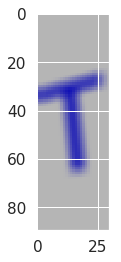

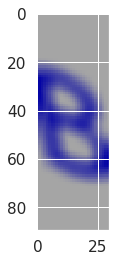

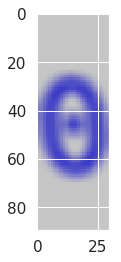

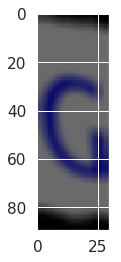

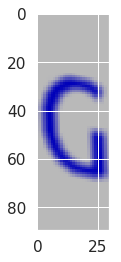

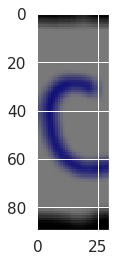

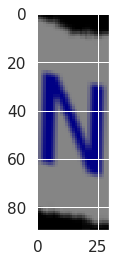

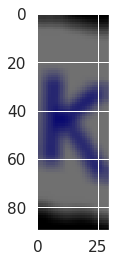

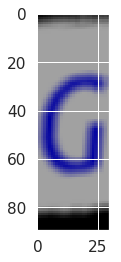

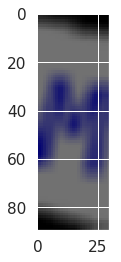

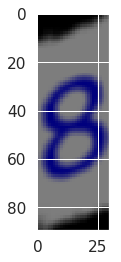

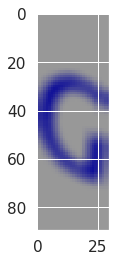

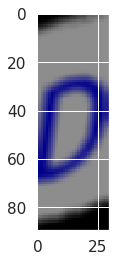

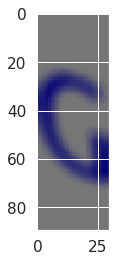

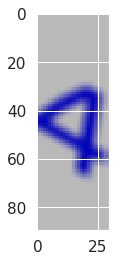

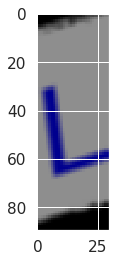

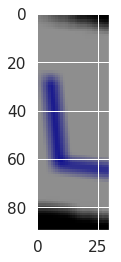

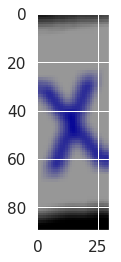

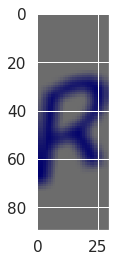

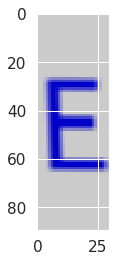

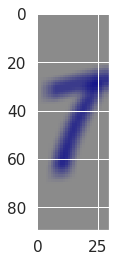

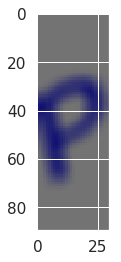

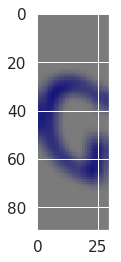

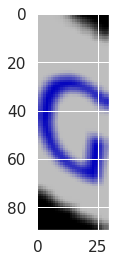

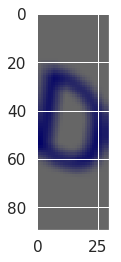

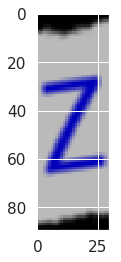

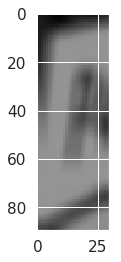

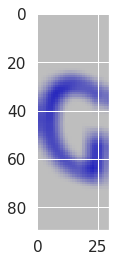

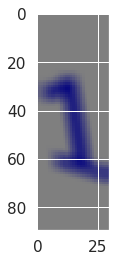

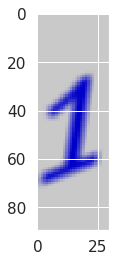

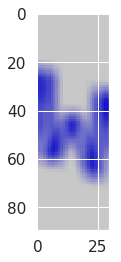

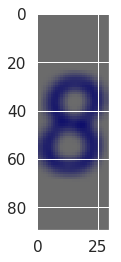

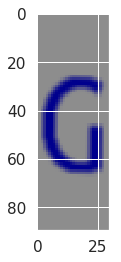

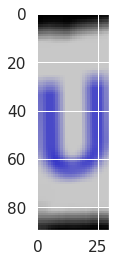

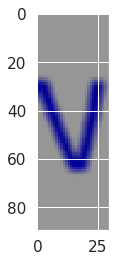

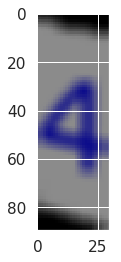

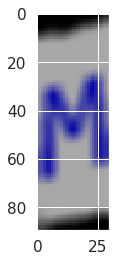

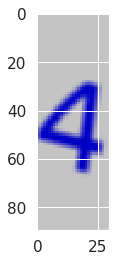

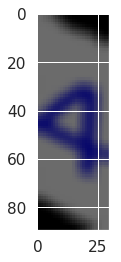

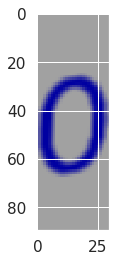

(3280, 90, 30, 3)


In [210]:
# see what images look like
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from numpy import expand_dims

# it = train_datagen.flow(samples, batch_size=1)

labels = "0123456789?ABCDEFGHIJKLMNOPQRSTUVWXYZ"
l_ar = [x for x in labels]

X = []
Y = []

for i in range(40):
    batch = train_generator.next()
    # print(batch[1])
    #print(batch[1][0])
    #print(batch[1][1])
    image = batch[0].astype('uint8')
    plt.imshow(image[0])
    plt.show()
#     plt.imshow(image[1])
#     plt.show()
    
    for j in range(82):
        # get label
        label = batch[1][j].tolist()
        ind = label.index(1)
        temp = cv2.cvtColor(image[j], cv2.COLOR_BGR2GRAY)
        temp = cv2.cvtColor(temp, cv2.COLOR_GRAY2BGR)

        X.append(temp/255.)
        Y.append(label)

X = np.array(X)
Y = np.array(Y)
print(X.shape)

In [ ]:
# code for writing to directory if needed

        # print(l_ar[ind])
#         plt.imshow(image[j])
#         plt.show()
        
#         try:
#             os.mkdir(pic_path+"train2/{}/".format(l_ar[ind]))
#         except:
#             # print("already did this one")
#             fsfsda = 0
            
        
#         cv2.imwrite(os.path.join(pic_path + "train2/{}/".format(l_ar[ind]), 
#                             "{}_{}.png".format(i, j)), image[j])
        
        

In [154]:
# same thing for validation data
X_v = []
Y_v = []

for i in range(4):
    batch = val_generator.next()
    # print(batch[1])
    #print(batch[1][0])
    #print(batch[1][1])
    image = batch[0].astype('uint8')
#     plt.imshow(image[1])
#     plt.show()
    
    for j in range(188):
        # get label
        label = batch[1][j].tolist()
        ind = label.index(1)
        temp = cv2.cvtColor(image[j], cv2.COLOR_BGR2GRAY)
        temp = cv2.cvtColor(temp, cv2.COLOR_GRAY2BGR)
        
        X_v.append(temp/255.)
        Y_v.append(label)

X_v = np.array(X_v)
Y_v = np.array(Y_v)
print(X_v.shape)

(752, 90, 30, 3)


In [12]:
# re-initialize model parameters. not 100% on what this means TODO figure this out
def reset_weights(model):
    session = backend.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

In [204]:
# this is the CNN Miti uses. TODO rearrange this and see what happens
conv_model = models.Sequential()
conv_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                             input_shape=(90, 30, 3)))  # from C.shape
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
# conv_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Flatten())
conv_model.add(layers.Dropout(0.5))
conv_model.add(layers.Dense(512, activation='relu'))
conv_model.add(layers.Dense(37, activation='softmax'))  # at least i think it is num labels

In [92]:
# get a summary of what the model looks like
conv_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 88, 28, 32)        896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 44, 14, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 42, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 21, 6, 64)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 8064)              0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 8064)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)              

In [205]:
# sets learning rate of model, and also type(?) for cats+dogs was 
#     binary_xentropy but this needs to be more than 2 so use categorical_xentropy
LEARNING_RATE = 1e-4
conv_model.compile(loss='categorical_crossentropy',
                   optimizer=optimizers.RMSprop(lr=LEARNING_RATE),
                   metrics=['acc'])

In [211]:
reset_weights(conv_model)

In [212]:
# this is training
#n_samples = 820  # total number of sample images (?)
#batch_size = 82  # training samples used in each iteration (defaults to 32 in train_generator)
history_conv = conv_model.fit(X, Y, validation_data=(X_v,Y_v), epochs=10, batch_size=32)
#history_conv = conv_model.fit_generator(train_generator, 
#                          steps_per_epoch=n_samples/batch_size, 
#                          epochs=40, 
#                          validation_data=val_generator,
#                          validation_steps=20)

Train on 3280 samples, validate on 752 samples
Epoch 1/10
3280/3280 [==============================] - 9s 3ms/step - loss: 3.5641 - acc: 0.0723 - val_loss: 3.6258 - val_acc: 0.0106
Epoch 2/10
3280/3280 [==============================] - 9s 3ms/step - loss: 3.4564 - acc: 0.0823 - val_loss: 3.5040 - val_acc: 0.0160
Epoch 3/10
3280/3280 [==============================] - 9s 3ms/step - loss: 2.8350 - acc: 0.2860 - val_loss: 3.0314 - val_acc: 0.2021
Epoch 4/10
3280/3280 [==============================] - 9s 3ms/step - loss: 1.5090 - acc: 0.6902 - val_loss: 3.1084 - val_acc: 0.2979
Epoch 5/10
3280/3280 [==============================] - 9s 3ms/step - loss: 0.6275 - acc: 0.8665 - val_loss: 4.1657 - val_acc: 0.3457
Epoch 6/10
3280/3280 [==============================] - 10s 3ms/step - loss: 0.3038 - acc: 0.9195 - val_loss: 5.3055 - val_acc: 0.3457
Epoch 7/10
3280/3280 [==============================] - 9s 3ms/step - loss: 0.1613 - acc: 0.9591 - val_loss: 6.1077 - val_acc: 0.3351
Epoch 8/10
328

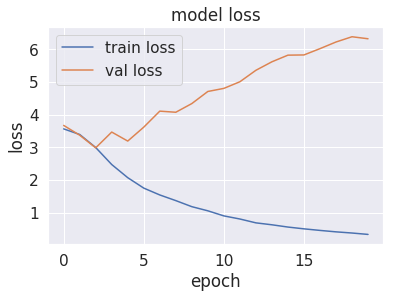

In [194]:
# showing training history
from matplotlib import pyplot as plt
plt.plot(history_conv.history['loss'])
plt.plot(history_conv.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')
plt.show()

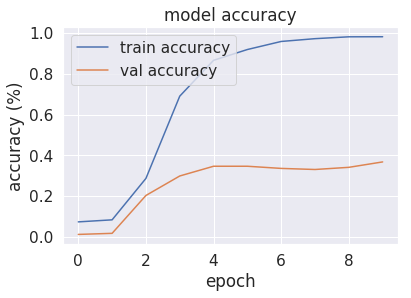

In [213]:
plt.plot(history_conv.history['acc'])
plt.plot(history_conv.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy (%)')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'val accuracy'], loc='upper left')
plt.show()

In [214]:
from sklearn.metrics import confusion_matrix
from ipywidgets import interact
import ipywidgets as ipywidgets
import seaborn as sn
import pandas as pd

# confusion_matrix(y_true, y_pred, other stuff)
# y_true = array like, shape (n_samples). correct target vals
# y_pred = as above shape. estimated targets


pred_vals = conv_model.predict(X_v, 16)
Y_v_new = np.argmax(Y_v, axis=1)
p_new = np.argmax(pred_vals, axis=1)
#print(Y_v_new)
#print(p_new)
#print(pred_vals)

cm = confusion_matrix(Y_v_new, p_new)

print(cm)

[[20  0  0 ...  0  0  0]
 [ 0 12  0 ...  0  0  0]
 [ 0  0 12 ...  0  0  8]
 ...
 [ 0  0  0 ...  0  0  4]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  4]]


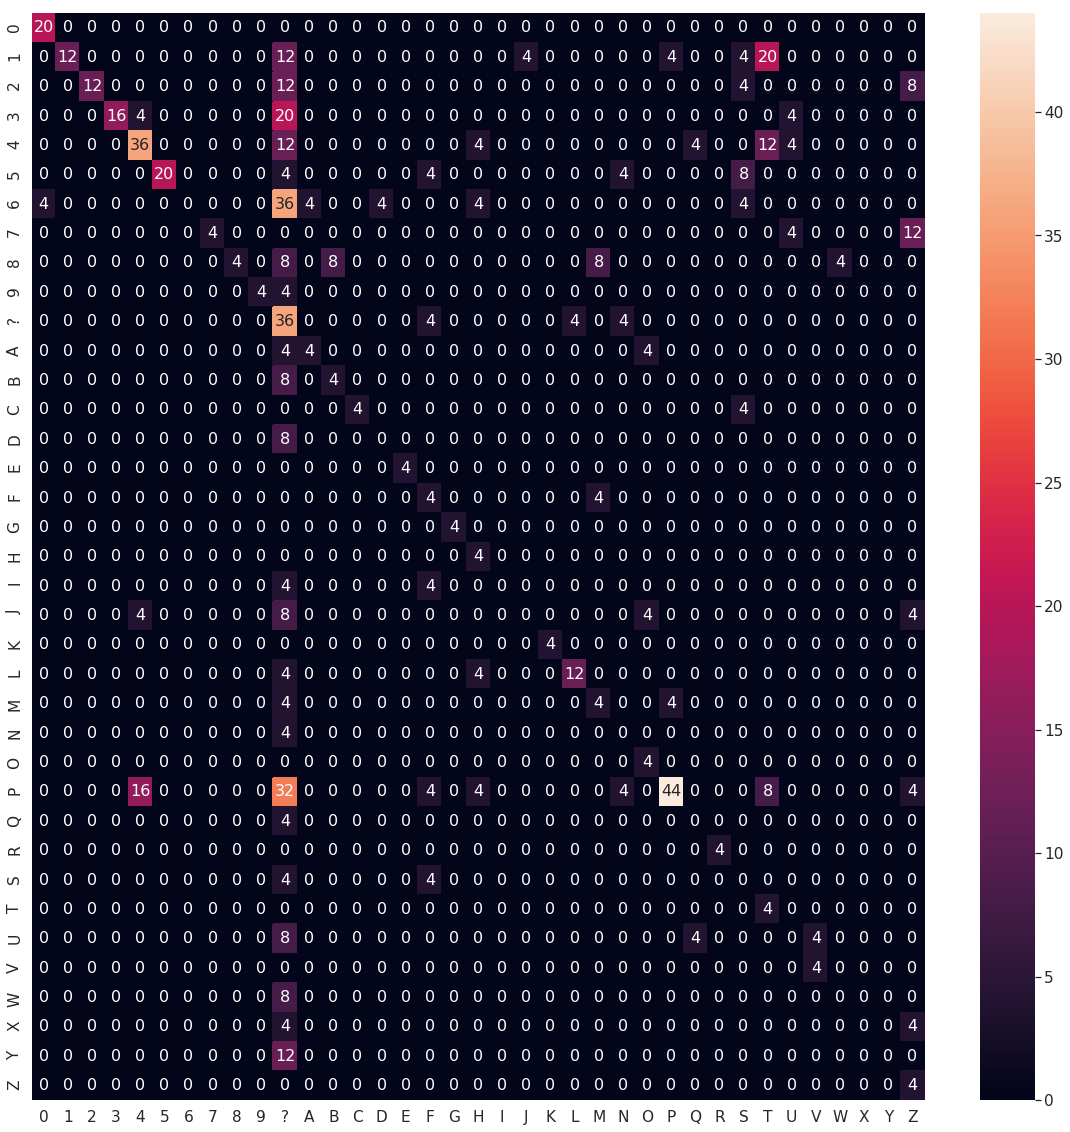

In [215]:
df_cm = pd.DataFrame(cm, (l for l in labels), (l for l in labels))
plt.figure(figsize=(20,20))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()